In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import xgboost as xgb

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
# from sklearn.boost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Gather Data

In [4]:
# Download latest version of splicing data
path = kagglehub.dataset_download("muhammetvarl/splicejunction-gene-sequences-dataset")

# create pandas dataframe from csv file downloaded above
df = pd.read_csv(f'{path}/dna.csv')

# output firts 5 rows of df
df.head()

100%|██████████| 101k/101k [00:00<00:00, 18.4MB/s]

Extracting files...


,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,3
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
2,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,3
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,2


In [5]:
# encode the class variable as (0,1,2) instead of (1,2,3) for xgboost to work
le = LabelEncoder()

df['class'] = le.fit_transform(df['class'])

df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,2
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,2
2,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,2
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,1


### visualize distribution of the three classes of outcome variabels (1: "EI site", 2:"IE Site" , 3: "Neither EI or IE Site" )

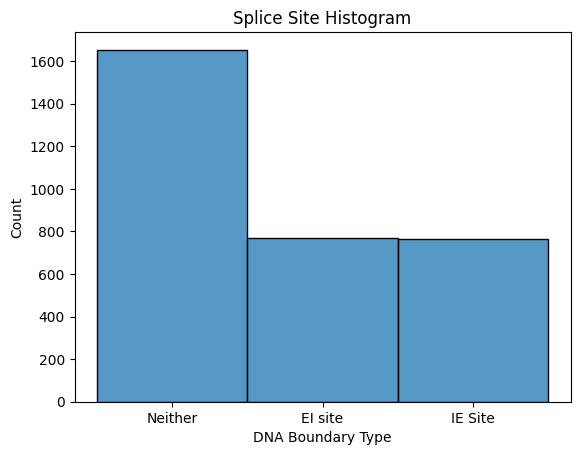

In [6]:
def create_class_name_column(df):
    # create a column with the boundary type based on the 'class' designation
    df['class_name'] = df['class'].apply(lambda x: 'EI site' if x == 0 
                                        else 'IE Site' if x == 1 
                                        else 'Neither' )

    return df

df = create_class_name_column(df)
# create frequency histogram of the different boundary types in the dataset
fig,ax=plt.subplots(nrows=1,ncols=1)
sns.histplot(df['class_name'], ax=ax)
ax.set_title('Splice Site Histogram')
ax.set_xlabel('DNA Boundary Type')
plt.show()

# drop the newly created column
df.drop(columns=['class_name'], inplace=True)

In [7]:
# copy dataframe to new df_copy
df_copy = df.copy()

# create combined train/validation and seperate testing x and y data sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df_copy.drop(columns='class'),
    df_copy['class'],
    test_size = 0.2,
    random_state=42
)

# create training and validation data sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.2,
    random_state=42
)

### - Run a randomized search cross validation over the following parameter distribution
### - Fit the model to the training data to get the best parameter combination (20 possible combinations of the parameters)

In [8]:
param_dist = {
    'max_depth': [5, 10, 15, 20, 25, 30, 25, 40],
    'max_features':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200]
}

# setting refit to neg rmse so that we use this as the scoring metric for the best model when fitting
random_forest_randomized_search_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions = param_dist,
    n_iter=20,
    cv=5,
    random_state=42
)

# fit randomizedSearch random forest model to training data
random_forest_randomized_search_cv.fit(X_train, np.ravel(y_train))

,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': [5, 10, ...], 'max_features': [0.1, 0.2, ...], 'n_estimators': [50, 100, ...]}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### Output the best Random Forest hyperparameters found using RandomizedSearchCV()

In [9]:
# get best parameters
best_params = random_forest_randomized_search_cv.best_params_

print(best_params)

results_df = random_forest_randomized_search_cv.cv_results_

{'n_estimators': 100, 'max_features': 0.1, 'max_depth': 30}


### Graph Hyperparameter vs. Test Score

Text(0, 0.5, 'avg test score')

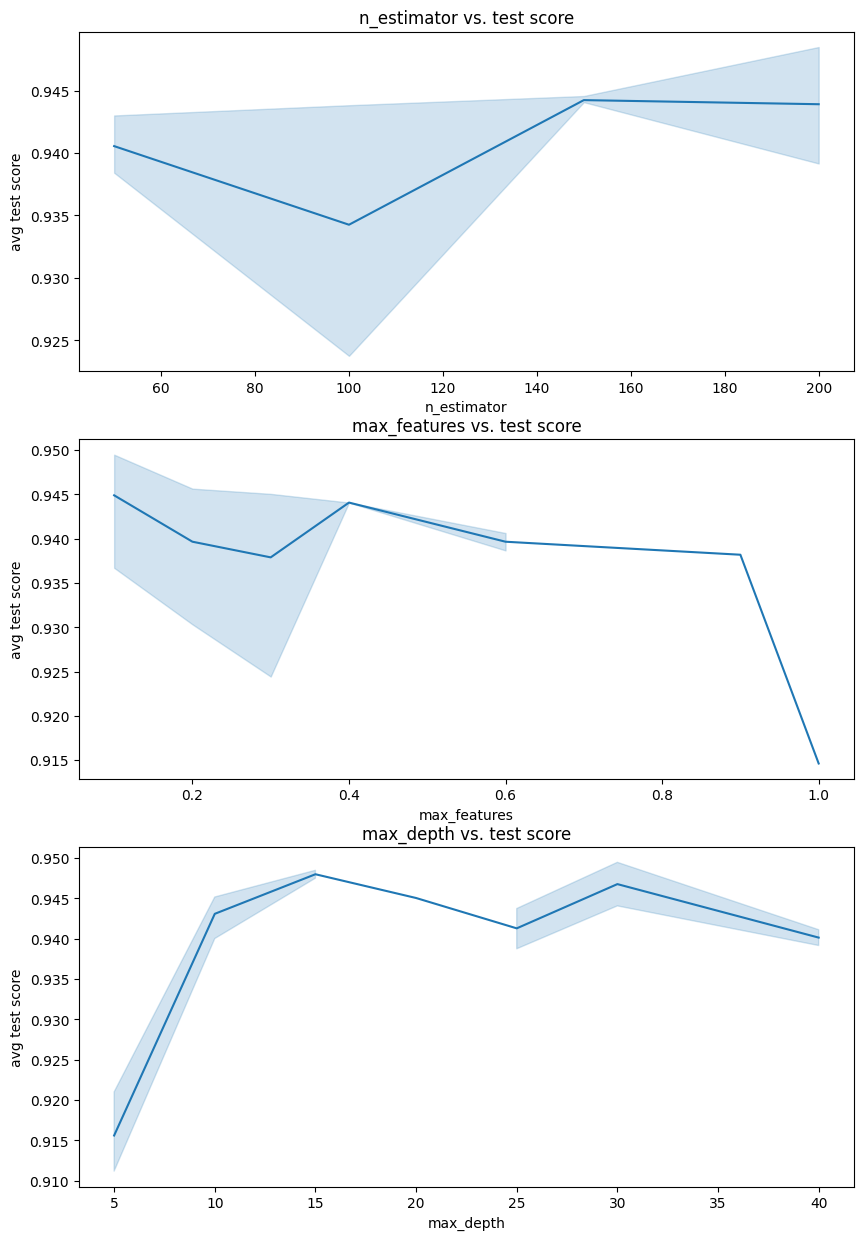

In [10]:
fig,ax = plt.subplots(nrows=3,ncols=1, figsize=(10, 15))

sns.lineplot(
    ax=ax[0],
    data=results_df,
    x='param_n_estimators',
    y='mean_test_score',
    estimator='mean'
)
ax[0].set_title('n_estimator vs. test score')
ax[0].set_xlabel('n_estimator')
ax[0].set_ylabel('avg test score')


sns.lineplot(
    ax=ax[1],
    data=results_df,
    x='param_max_features',
    y='mean_test_score',
    estimator='mean'
)
ax[1].set_title('max_features vs. test score')
ax[1].set_xlabel('max_features')
ax[1].set_ylabel('avg test score')

sns.lineplot(
    ax=ax[2],
    data=results_df,
    x='param_max_depth',
    y='mean_test_score',
    estimator='mean'
)
ax[2].set_title('max_depth vs. test score')
ax[2].set_xlabel('max_depth')
ax[2].set_ylabel('avg test score')

### Make predictions using validation data set

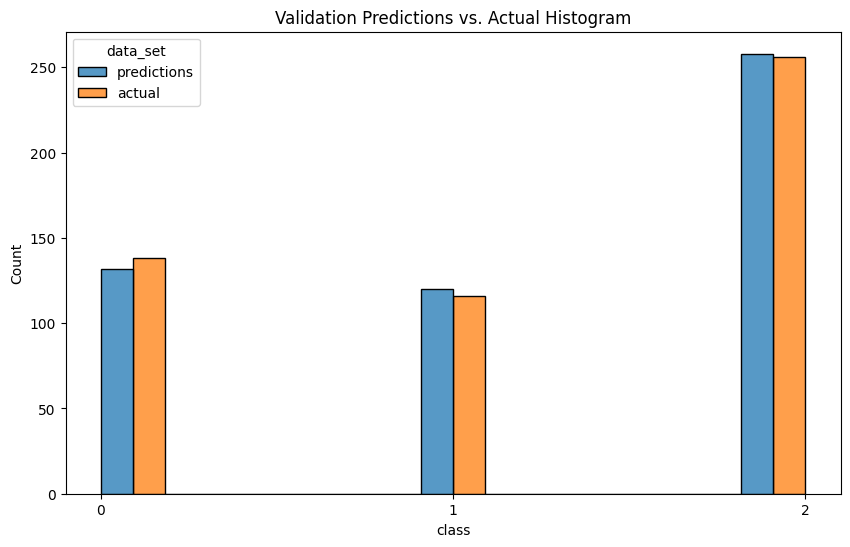

In [ ]:
predictions = random_forest_randomized_search_cv.predict(X=X_val)

validation_df = pd.DataFrame({
    'class': predictions,
    'data_set': 'predictions'
})

# print(y_val.columns[0])
actual_df = pd.DataFrame({
    'class': y_val,
    'data_set': 'actual'
})

actual_df.reset_index(drop=True, inplace=True)

vertical_stack = pd.concat([validation_df, actual_df], axis=0)

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax=ax, data=vertical_stack, x='class', hue='data_set', multiple="dodge")
ax.set_title("Validation Predictions vs. Actual Histogram")
ax.set_xticks(range(len(df['class'].unique())))

In [12]:
random_forest_accuracy = accuracy_score(y_val, predictions)

print(random_forest_accuracy)

0.9372549019607843


In [13]:
# get performance metric for each class
report = classification_report(y_val, predictions, target_names=df['class'].unique(), output_dict=True)
report2 = classification_report(y_val, predictions, target_names=df['class'].unique(), output_dict=True)
print(report2)

# output error rate for each class
for boundary_type in df['class'].unique():
    error_rate = 1-report[boundary_type]['recall']
    print(f'{boundary_type}: {error_rate}')

{np.int64(2): {'precision': 0.9545454545454546, 'recall': 0.9130434782608695, 'f1-score': 0.9333333333333333, 'support': 138.0}, np.int64(0): {'precision': 0.8833333333333333, 'recall': 0.9137931034482759, 'f1-score': 0.8983050847457628, 'support': 116.0}, np.int64(1): {'precision': 0.9534883720930233, 'recall': 0.9609375, 'f1-score': 0.9571984435797666, 'support': 256.0}, 'accuracy': 0.9372549019607843, 'macro avg': {'precision': 0.9304557199906037, 'recall': 0.9292580272363818, 'f1-score': 0.929612287219621, 'support': 510.0}, 'weighted avg': {'precision': 0.9378175738230459, 'recall': 0.9372549019607843, 'f1-score': 0.9373454733077035, 'support': 510.0}}
2: 0.08695652173913049
0: 0.08620689655172409
1: 0.0390625


### Gradient Boost Classifier

In [14]:
param_dist = {
    'learning_rate':[0.5, 0.75, 1.0],
    'max_depth': [3, 5, 10, 15, 20, 25, 30, 25, 40],
    'max_features':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200]
}

# setting refit to neg rmse so that we use this as the scoring metric for the best model when fitting
gradient_boost_randomized_search_cv = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(),
    param_distributions = param_dist,
    n_iter=20,
    cv=5,
    random_state=42)

gradeint_boost_classifier = gradient_boost_randomized_search_cv.fit(X_train, np.ravel(y_train))

In [15]:
gb_best_params = gradeint_boost_classifier.best_params_
print(gb_best_params)

{'n_estimators': 150, 'max_features': 0.9, 'max_depth': 3, 'learning_rate': 0.5}


### Make Predictions on Validation Set

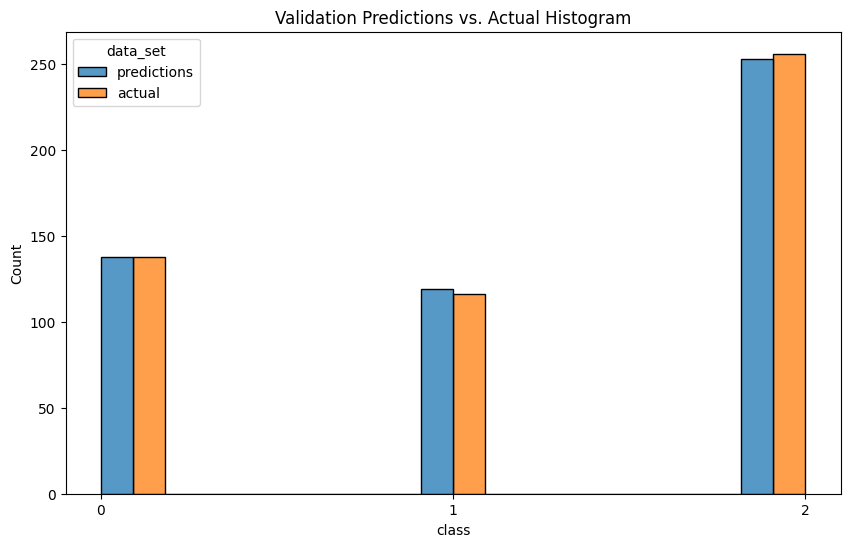

In [16]:
predictions = gradeint_boost_classifier.predict(X=X_val)

validation_df = pd.DataFrame({
    'class': predictions,
    'data_set': 'predictions'
})

# print(y_val.columns[0])
actual_df = pd.DataFrame({
    'class': y_val,
    'data_set': 'actual'
})

actual_df.reset_index(drop=True, inplace=True)

vertical_stack = pd.concat([validation_df, actual_df], axis=0)

vertical_stack.head()

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax=ax, data=vertical_stack, x='class', hue='data_set', multiple="dodge")
ax.set_title("Validation Predictions vs. Actual Histogram")
ax.set_xticks(range(len(df['class'].unique())))

### Get Accuracy Score for Gradient Boost Model

In [17]:
gradient_boost_accuracy = accuracy_score(y_val, predictions)

print(gradient_boost_accuracy)

0.9529411764705882


# XGBOOST

### Hypertune xgboost parameters using a manual function

In [18]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2,3,4,5],
    'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3]
}

def xgb_GridSearchCV(df_X, df_y, param_grid, cv, scoring, random_state):

    # create copy of x and y data frames and reset indices
    X = df_X.copy()
    y = df_y.copy()

    X.reset_index(drop=True, inplace=True)
    y = y.reset_index(drop=True)


    # instantiate Kfold cross validator
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # create best_score and best_params variables
    best_score = 0
    best_params = {}

    # loop through all combinations of parameters
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:

                fold_scores = []
                # get training and validation indexes using Kfold
                for train_index, val_index in kf.split(X):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                    # instantiate model
                    xgb_clf = xgb.XGBClassifier(n_estimators=n_estimators, 
                                                max_depth=max_depth, 
                                                learning_rate = learning_rate,
                                                eval_metric='mlogloss', 
                                                early_stopping_rounds = 10)
                    
                    # fit xgboost model on training data
                    xgb_clf.fit(X_train, y_train,
                            eval_set = [(X_val, y_val)],
                            verbose = False)
                    
                    # use xgboost model to predict classes on validation data
                    y_pred = xgb_clf.predict(X_val)

                    # measure score of model with current parameters
                    fold_score = accuracy_score(y_true=y_val, y_pred=y_pred)

                    # append to list of scores for this round of cross validation
                    fold_scores.append(fold_score)
                    
                # take mean of scores for this round of cross validation
                # see how mean score for this round of cv compares to previous best score
                # if it is better than previous best score, set new best_params to the current n_estimators and max_depth
                if np.mean(fold_scores) > best_score:
                    best_score = np.mean(fold_scores)
                    best_params['n_estimators'] = n_estimators
                    best_params['max_depth'] = max_depth
                    best_params['learning_rate'] = learning_rate


    return best_params, best_score

xgb_GridSearchCV(X_train, y_train, param_grid=param_grid, cv = 5, scoring='mlogloss', random_state=42)

ImportError: sklearn needs to be installed in order to use this module

### Create xgboost classifier using best parameters and early stopping

In [ ]:
# instantiate model
xgb_clf_best = xgb.XGBClassifier(objective='multi:softprob', 
                                 n_estimators=150, 
                                 max_depth=3, 
                                 learning_rate = 0.08,
                                 eval_metric='mlogloss',
                                 early_stopping_rounds = 10)

# fit xgboost model on training data
xgb_clf_best.fit(X_train, y_train, 
                 eval_set=[(X_train, y_train), (X_val, y_val)], 
                 verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

### Create Plot of Log Loss Over Different Number of Trees

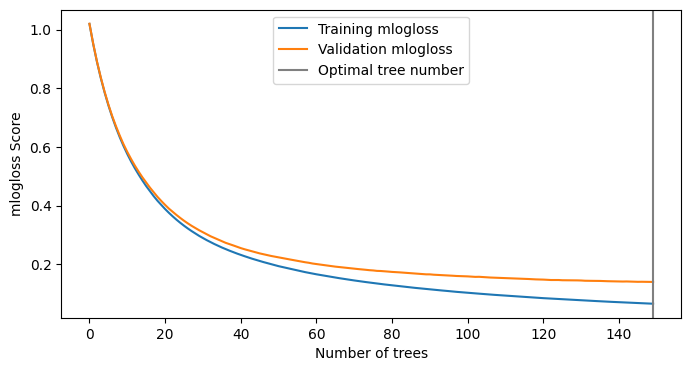

In [ ]:
# get evaluation results from fitting
results = xgb_clf_best.evals_result()

# create plot of evaluation score for training and validation data asets
plt.figure(figsize=(8, 4))
plt.plot(results['validation_0']['mlogloss'], label="Training mlogloss")
plt.plot(results['validation_1']['mlogloss'], label="Validation mlogloss")
plt.axvline(xgb_clf_best.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("mlogloss Score")
plt.legend()
plt.show()

### Create Histogram Comparing XGBoost predictions on validation set with actual class labels of validation set

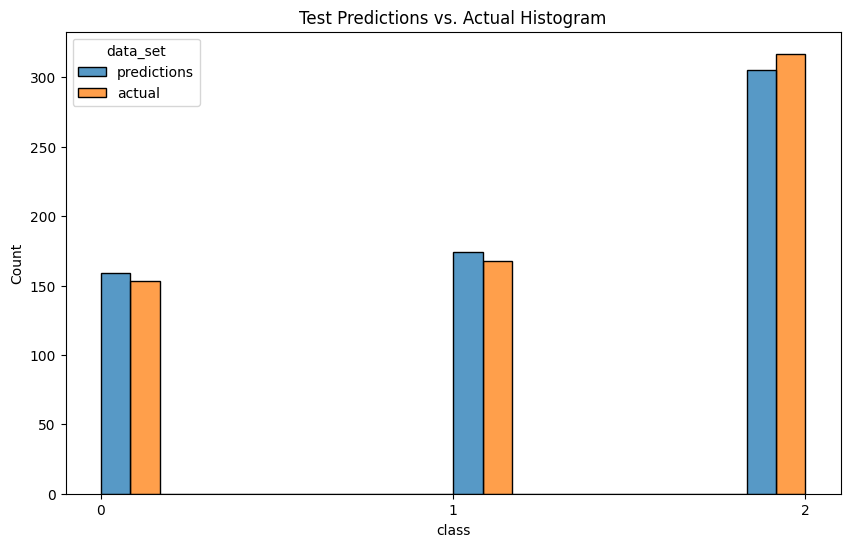

In [ ]:
predictions = xgb_clf_best.predict(X=X_test)

validation_df = pd.DataFrame({
    'class': predictions,
    'data_set': 'predictions'
})

# print(y_val.columns[0])
actual_df = pd.DataFrame({
    'class': y_test,
    'data_set': 'actual'
})

actual_df.reset_index(drop=True, inplace=True)

vertical_stack = pd.concat([validation_df, actual_df], axis=0)

vertical_stack.head()

# validation_df.head()

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax=ax, data=vertical_stack, x='class', hue='data_set', multiple="dodge")
ax.set_title("Test Predictions vs. Actual Histogram")
ax.set_xticks(range(len(df['class'].unique())))

# Get Accuracy Score of XGBoost Model

In [ ]:
score = accuracy_score(y_true=y_test, y_pred = predictions)

print(score)

0.9561128526645768


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2,3,4,5],
    'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3],
    'rate_drop': [0.2, 0.4, 0.6, 0.8],
    'skip_drop': [0.2, 0.4, 0.6, 0.8]
}

def xgb_dart_GridSearchCV(df_X, df_y, param_grid, cv, scoring, random_state):

    # create copy of x and y data frames and reset indices
    X = df_X.copy()
    y = df_y.copy()

    X.reset_index(drop=True, inplace=True)
    y = y.reset_index(drop=True)


    # instantiate Kfold cross validator
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # create best_score and best_params variables
    best_score = 0
    best_params = {}

    # loop through all combinations of parameters
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for rate_drop in param_grid['rate_drop']:
                    for skip_drop in param_grid['skip_drop']:

                        fold_scores = []
                        # get training and validation indexes using Kfold
                        for train_index, val_index in kf.split(X):
                            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                            # instantiate model
                            xgb_clf = xgb.XGBClassifier(n_estimators=n_estimators,
                                                        booster='dart',
                                                        max_depth=max_depth, 
                                                        learning_rate = learning_rate,
                                                        rate_drop = rate_drop,
                                                        skip_drop = skip_drop,
                                                        eval_metric='mlogloss', 
                                                        early_stopping_rounds = 10)
                            
                            # fit xgboost model on training data
                            xgb_clf.fit(X_train, y_train,
                                    eval_set = [(X_val, y_val)],
                                    verbose = False)
                            
                            # use xgboost model to predict classes on validation data
                            y_pred = xgb_clf.predict(X_val)

                            # measure score of model with current parameters
                            fold_score = accuracy_score(y_true=y_val, y_pred=y_pred)

                            # append to list of scores for this round of cross validation
                            fold_scores.append(fold_score)
                            
                        # take mean of scores for this round of cross validation
                        # see how mean score for this round of cv compares to previous best score
                        # if it is better than previous best score, set new best_params to the current n_estimators and max_depth
                        if np.mean(fold_scores) > best_score:
                            best_score = np.mean(fold_scores)
                            best_params['n_estimators'] = n_estimators
                            best_params['max_depth'] = max_depth
                            best_params['learning_rate'] = learning_rate


    return best_params, best_score

xgb_dart_GridSearchCV(X_train, y_train, param_grid=param_grid, cv = 5, scoring='mlogloss', random_state=42)

KeyboardInterrupt: 

In [ ]:
# instantiate model
xgb_dart_clf_best = xgb.XGBClassifier(
                                      booster="dart",
                                 n_estimators=150, 
                                 max_depth=3, 
                                 learning_rate = 0.08,
                                 eval_metric='mlogloss',
                                 rate_drop=0.1,  # Fraction of trees to drop
                                 skip_drop=0.5,  # Probability of skipping dropout
                                 early_stopping_rounds = 10)

# fit xgboost model on training data
xgb_dart_clf_best.fit(X_train, y_train, 
                 eval_set=[(X_train, y_train), (X_val, y_val)], 
                 verbose=False)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

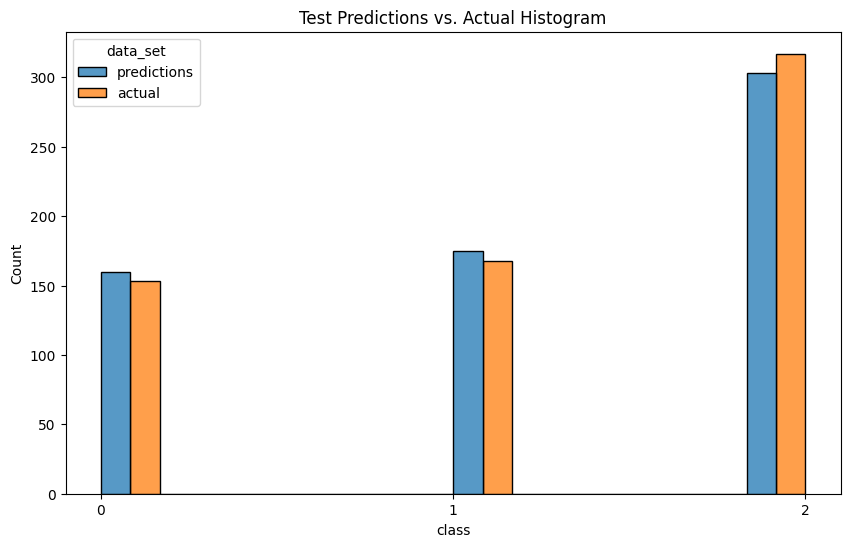

In [ ]:
new_predictions = xgb_dart_clf_best.predict(X=X_test)

validation_df = pd.DataFrame({
    'class': new_predictions,
    'data_set': 'predictions'
})

# print(y_val.columns[0])
actual_df = pd.DataFrame({
    'class': y_test,
    'data_set': 'actual'
})

actual_df.reset_index(drop=True, inplace=True)

vertical_stack = pd.concat([validation_df, actual_df], axis=0)

vertical_stack.head()

# validation_df.head()

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax=ax, data=vertical_stack, x='class', hue='data_set', multiple="dodge")
ax.set_title("Test Predictions vs. Actual Histogram")
ax.set_xticks(range(len(df['class'].unique())))

In [ ]:
score = accuracy_score(y_true=y_test, y_pred = new_predictions)

print(score)

0.9561128526645768
